In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'D:\diabetic retinopathy/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

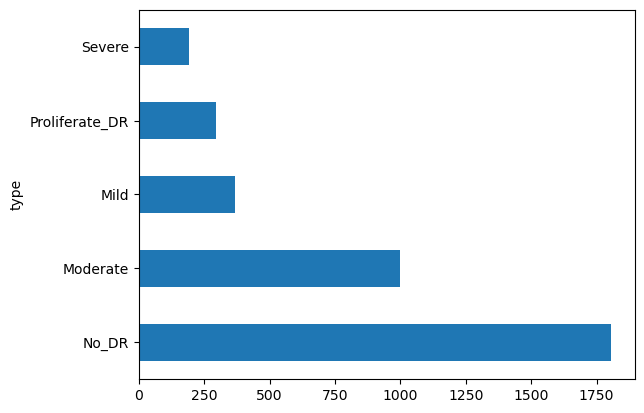

In [3]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

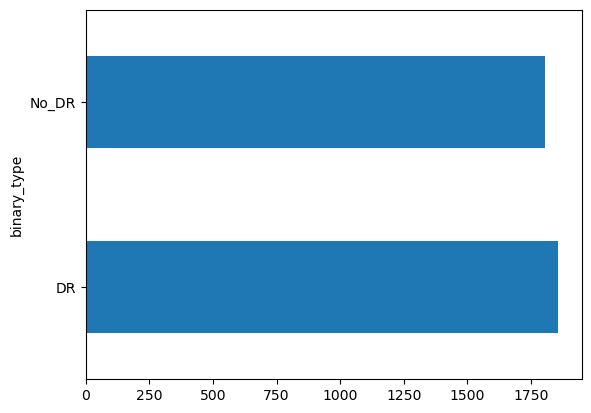

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [7]:
# Copy images to respective working directory
src_dir = r'D:\diabetic retinopathy\gaussian_filtered_images\gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [8]:
# Setting up ImageDataGenerator for train/val/test
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

# Load VGG16 pre-trained model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # VGG16 base model
    layers.GlobalAveragePooling2D(),  # Global Average Pooling
    layers.Dense(32, activation='relu'),  # Fully connected layer
    layers.Dropout(0.15),  # Dropout layer
    layers.Dense(2, activation='softmax')  # Output layer for 2 classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

# Train the model
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

# Evaluate the model
loss, acc = model.evaluate(test_batches, verbose=1)

# Print results
print("Loss: ", loss)
print("Accuracy: ", acc)


Epoch 1/30


C:\Users\datapro\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - acc: 0.4727 - loss: 0.7819 - val_acc: 0.4927 - val_loss: 0.7475
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - acc: 0.4924 - loss: 0.7526 - val_acc: 0.4927 - val_loss: 0.7312
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - acc: 0.4814 - loss: 0.7417 - val_acc: 0.4927 - val_loss: 0.7162
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - acc: 0.5122 - loss: 0.7198 - val_acc: 0.4927 - val_loss: 0.7017
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - acc: 0.5293 - loss: 0.6986 - val_acc: 0.4927 - val_loss: 0.6902
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - acc: 0.5189 - loss: 0.6969 - val_acc: 0.4927 - val_loss: 0.6803
Epoch 7/30
45/81 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - acc: 0.5363 - loss: 0.6907

In [ ]:
# Assuming `model` is your trained Keras model
model.save("CNN.h5")  # Save in HDF5 format


In [ ]:
# Evaluate the model using the 'evaluate' method
loss, acc = model.evaluate(test_batches, verbose=1)

# Print results
print("Loss: ", loss)
print("Accuracy: ", acc)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model using the 'evaluate' method
loss, acc = model.evaluate(test_batches, verbose=1)

# Print results
print("Loss: ", loss)
print("Accuracy: ", acc)

# Generate predictions from the test data
y_pred = model.predict(test_batches)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get true labels from test_batches
y_true = test_batches.classes  # Assuming test_batches is a generator with true labels

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_batches.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# ****Diabet Retinopathy Detection Section****

In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = tf.keras.models.load_model(r'D:\diabetic retinopathy\CNN.h5')  # Replace with your model path

# Function to predict image
def predict_image(img):
    # Preprocess the image (resizing and scaling)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0  # Rescale the image
    
    # Add batch dimension (as the model expects 4D input)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array)
    
    # Get predicted class
    class_names = ['Diabetic Retinopathy', 'No Diabetic Retinopathy']  # Replace with your class names
    predicted_class = class_names[np.argmax(predictions)]
    
    return predicted_class, predictions[0][np.argmax(predictions)]

# Build Gradio interface
iface = gr.Interface(fn=predict_image, 
                     inputs=gr.Image(type="pil"), 
                     outputs=[gr.Label(), gr.Textbox()],
                     live=True)

# Launch the Gradio app
iface.launch()
